In [ ]:
# import

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001


In [ ]:
# Load CIFAR-100 dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, std_dev):
        super(GaussianNoiseLayer, self).__init__()
        self.std_dev = std_dev
    def forward(self, x):
        noise = torch.randn_like(x) * self.std_dev
        return x + noise

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.gaussian_noise = GaussianNoiseLayer(std_dev=0.0)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = (8*8*8)*x/torch.norm(x)
        x = self.gaussian_noise(x)
        x = self.decoder(x)
        return x



In [ ]:
from torchsummary import summary

# Instantiate the autoencoder model
model = Autoencoder().to(device)

# Display the model summary
summary(model, (3, 32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3              [-1, 8, 8, 8]           1,160
              ReLU-4              [-1, 8, 8, 8]               0
GaussianNoiseLayer-5              [-1, 8, 8, 8]               0
   ConvTranspose2d-6           [-1, 16, 16, 16]           1,168
              ReLU-7           [-1, 16, 16, 16]               0
   ConvTranspose2d-8            [-1, 3, 32, 32]             435
              Tanh-9            [-1, 3, 32, 32]               0
Total params: 3,211
Trainable params: 3,211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.18
Params size (MB): 0.01
Estimated Total Size (MB): 0.21
-----------------------------------------------

In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/25], Step [100/782], Loss: 0.0572
Epoch [1/25], Step [200/782], Loss: 0.0266
Epoch [1/25], Step [300/782], Loss: 0.0226
Epoch [1/25], Step [400/782], Loss: 0.0190
Epoch [1/25], Step [500/782], Loss: 0.0165
Epoch [1/25], Step [600/782], Loss: 0.0162
Epoch [1/25], Step [700/782], Loss: 0.0141
Epoch [2/25], Step [100/782], Loss: 0.0130
Epoch [2/25], Step [200/782], Loss: 0.0141
Epoch [2/25], Step [300/782], Loss: 0.0119
Epoch [2/25], Step [400/782], Loss: 0.0110
Epoch [2/25], Step [500/782], Loss: 0.0132
Epoch [2/25], Step [600/782], Loss: 0.0121
Epoch [2/25], Step [700/782], Loss: 0.0120
Epoch [3/25], Step [100/782], Loss: 0.0114
Epoch [3/25], Step [200/782], Loss: 0.0129
Epoch [3/25], Step [300/782], Loss: 0.0114
Epoch [3/25], Step [400/782], Loss: 0.0128
Epoch [3/25], Step [500/782], Loss: 0.0119
Epoch [3/25], Step [600/782], Loss: 0.0101
Epoch [3/25], Step [700/782], Loss: 0.0111
Epoch [4/25], Step [100/782], Loss: 0.0112
Epoch [4/25], Step [200/782], Loss: 0.0094
Epoch [4/25

In [ ]:
# Testing the autoencoder
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        break

Original Images:


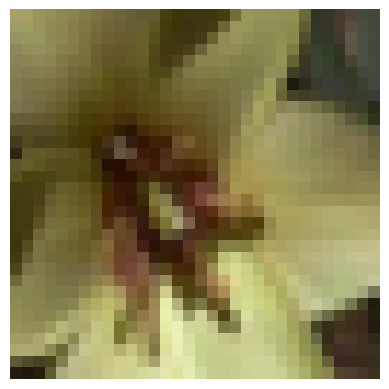

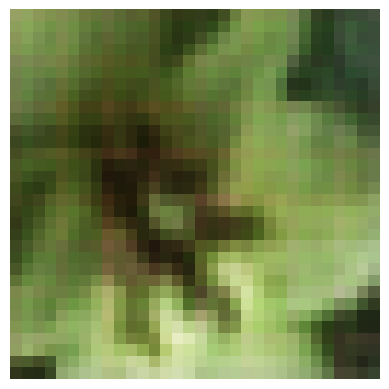

Reconstructed Images:


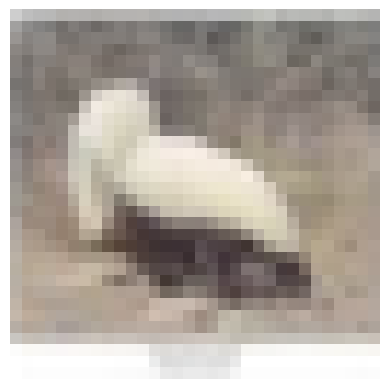

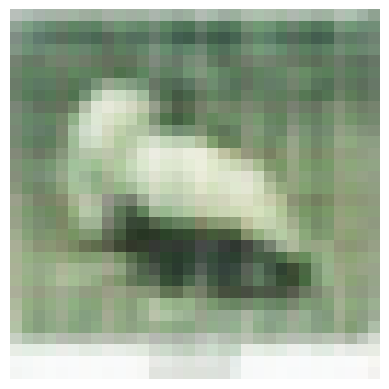

In [ ]:
import numpy as np

# Plotting the original and reconstructed images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display original images
print('Original Images:')
imshow(torchvision.utils.make_grid(images[5]))
imshow(torchvision.utils.make_grid(outputs[5]))
# Display reconstructed images
print('Reconstructed Images:')
imshow(torchvision.utils.make_grid(images[11]))
imshow(torchvision.utils.make_grid(outputs[11]))

In [ ]:
torch.save(model,"comm_model_std00.pt")

In [ ]:
from google.colab import files
files.download("comm_model_std00.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>